### Download data

In [1]:
from download_files import download

download()

../data/all_rain_future_4p5_years_sums_75km.nc exists
../data/all_rain_future_8p5_years_sums_75km.nc exists
../data/all_rain_historical_years_sums_75km.nc exists
../data/mcs_rain_future_4p5_years_sums_75km.nc exists
../data/mcs_rain_future_8p5_years_sums_75km.nc exists
../data/mcs_rain_historical_years_sums_75km.nc exists
../data/non_mcs_rain_future_4p5_years_sums_75km.nc exists
../data/non_mcs_rain_future_8p5_years_sums_75km.nc exists
../data/non_mcs_rain_historical_years_sums_75km.nc exists
../data/CONUS.cpg exists
../data/CONUS.dbf exists
../data/CONUS.prj exists
../data/CONUS.sbn exists
../data/CONUS.sbx exists
../data/CONUS.shp exists
../data/CONUS.shp.xml exists
../data/CONUS.shx exists


## Read in the data

In [2]:
import xarray as xr

data = {}

for event_type in ['all_rain', 'mcs_rain', 'non_mcs_rain']:
    
    data[event_type] = {}
    
    for simulation in ['historical', 'future_4p5', 'future_8p5']:
        
        data[event_type][simulation] = {}
        
        ds_event = xr.open_dataset(f"../data/{event_type}_{simulation}_years_sums_75km.nc")
        
        data[event_type][simulation]['years_sums'] = ds_event
        data[event_type][simulation]['annual_mean'] = ds_event.mean('time')
            
data['all_rain']['historical']['years_sums']

<xarray.Dataset>
Dimensions:   (time: 15, south_north: 44, west_east: 69)
Coordinates:
  * time      (time) datetime64[ns] 1990-10-01 1991-10-01 ... 2004-10-01
    lat       (south_north, west_east) float32 ...
    lon       (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Data variables:
    mcs_mask  (time, south_north, west_east) float32 29.76 59.47 ... 697.8 721.6
Attributes:
    info_read:      ds = xr.open_mfdataset(f'redacted/Analysis_Datasets/rain_...
    info_resample:  ds.resample(time='AS-OCT').sum('time')
    info_rename:    ds1.rename({'Time': 'time', 'AFWA_TOTPRECIP': 'mcs_mask'}...
    english:        I am opening all of the 1-hr rainfall totals that were ag...
    made_on:        Calculated by A. Haberlie on April 20th 2023
    date_range:     Start of 1990-10-01T00:00:00.000000000 to start of 2005-0...
    simulation:     historical
    units:          mm
    month_count:    180
    years_count:    15

### Create ratios of MCS to ALL Precipitation

In [3]:
data['mcs_ratio'] = {}
data['non_mcs_rain'] = {}

for simulation in ['historical', 'future_4p5', 'future_8p5']:
    
    data['mcs_ratio'][simulation] = {}
    data['non_mcs_rain'][simulation] = {}
        
    mcs_years = data['mcs_rain'][simulation]['years_sums']
    all_years = data['all_rain'][simulation]['years_sums']
        
    years_ratio =  mcs_years / all_years
    years_diff = all_years - mcs_years
        
    mcs_means = data['mcs_rain'][simulation]['annual_mean']
    all_means = data['all_rain'][simulation]['annual_mean']
        
    means_ratio =  mcs_means / all_means
    means_diff = all_means - mcs_means

    data['mcs_ratio'][simulation]['years_sums'] = years_ratio
    data['mcs_ratio'][simulation]['annual_mean'] = means_ratio
    
    data['non_mcs_rain'][simulation]['years_sums'] = years_diff
    data['non_mcs_rain'][simulation]['annual_mean'] = means_diff

### Set up mapping utilities and customization

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import copy
import xarray as xr
import numpy as np
import geopandas as gpd

from ax import setup_map, draw_outlines, grid_significance
    
projection = cartopy.crs.LambertConformal(central_longitude=-96, central_latitude=37.5, standard_parallels=(29.5, 45.5))

### Plot original values

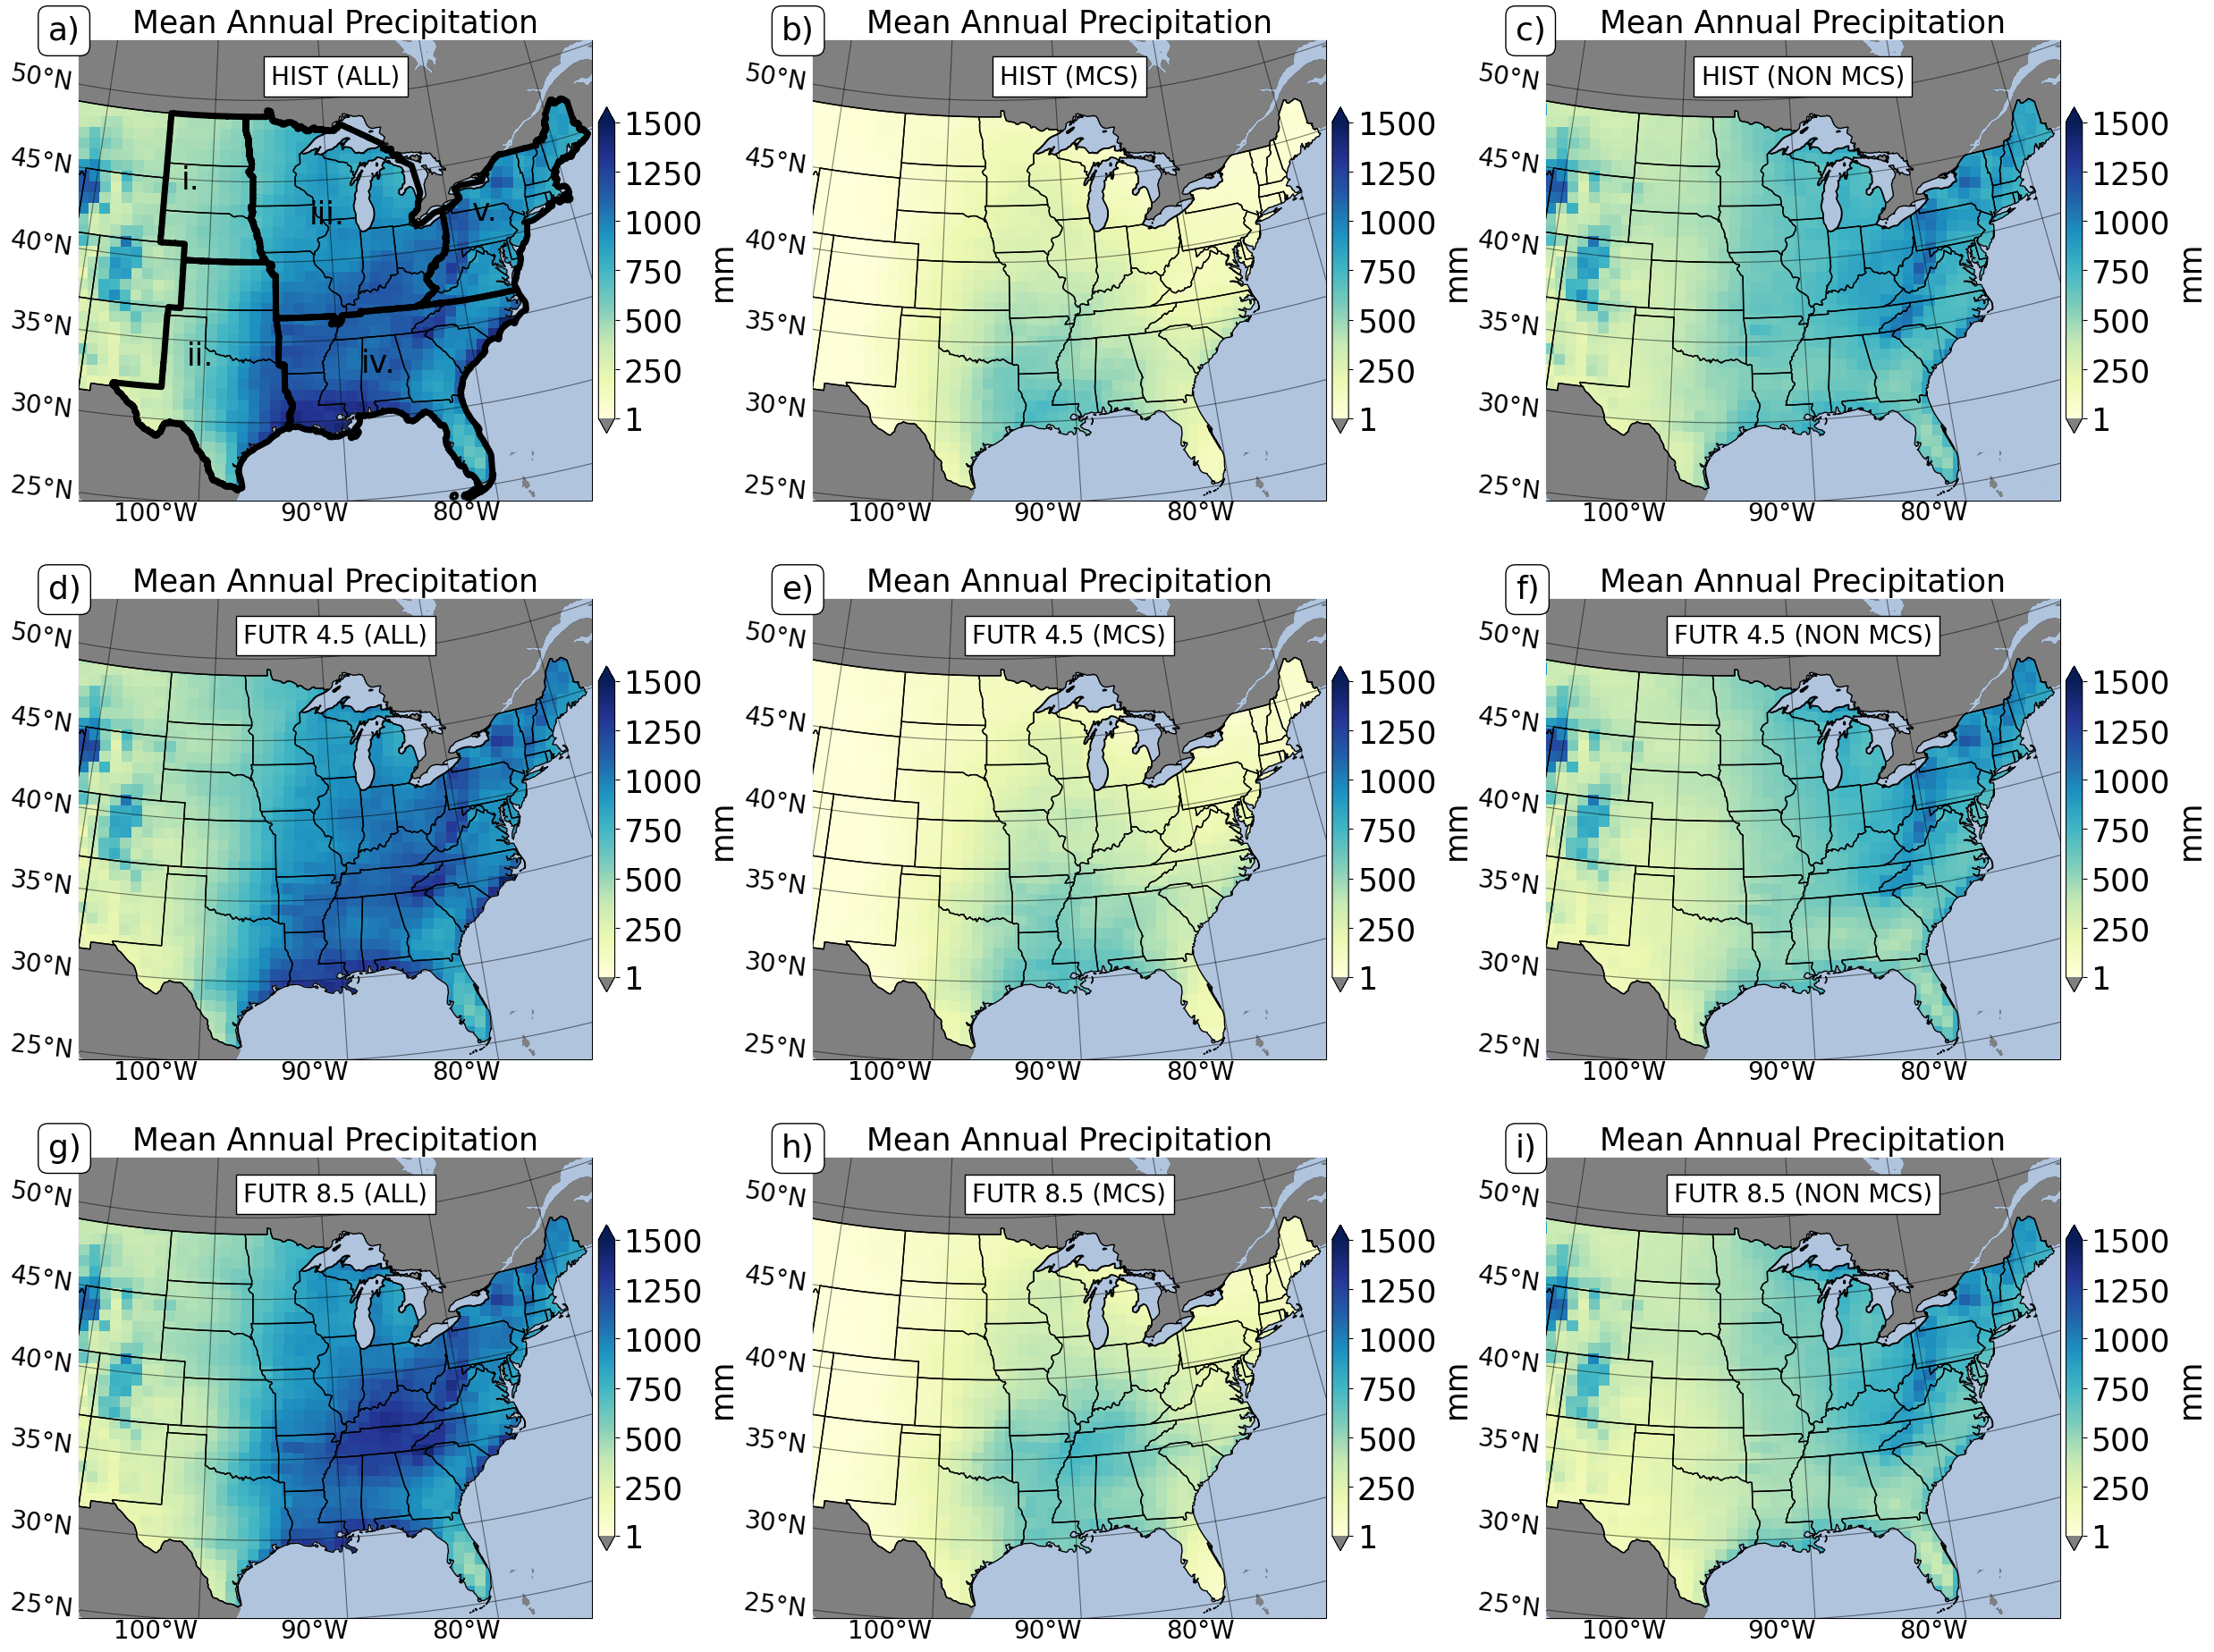

In [5]:
plt.rcParams['figure.figsize'] = 30, 23
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 25

cmap = plt.cm.get_cmap("YlGnBu").copy()
cmap.set_under('grey')

simulation_names = {'historical': 'HIST', 'future_4p5': 'FUTR 4.5', 'future_8p5': 'FUTR 8.5'}
event_types = {'all_rain': 'ALL', 'mcs_rain': 'MCS', 'non_mcs_rain': 'NON MCS'}

for row, (sim_name, sim_abbr) in enumerate(simulation_names.items()):
    
    for col, (event_name, event_abbr) in enumerate(event_types.items()):
        
        ax_pos = 1 + ((row * 3) + col)

        simulation_means = data[event_name][sim_name]['annual_mean']
        
        ax = setup_map(ax_pos, 3, 3, ax_pos)
        
        ax.set_title(f"Mean Annual Precipitation")
        
        ax.annotate(f"{sim_abbr} ({event_abbr})", (0.5,0.92), 
                    xycoords='axes fraction', ha='center', va='center',
                    fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                    color='k', zorder=15)
        
        if ax_pos == 1:
            
            draw_outlines(ax)
        
        mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                            simulation_means['mcs_mask'], 
                            vmin=1, vmax=1500,
                            transform=cartopy.crs.PlateCarree(), 
                            cmap=cmap, zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', 
                            ticks=[1, 250, 500, 750, 1000, 1250, 1500], pad=0.01)
        
        cbar.set_label(label="mm")
        
plt.savefig(f"original_annual_052323.png", dpi=200, bbox_inches='tight')

### Plot MCS ratios

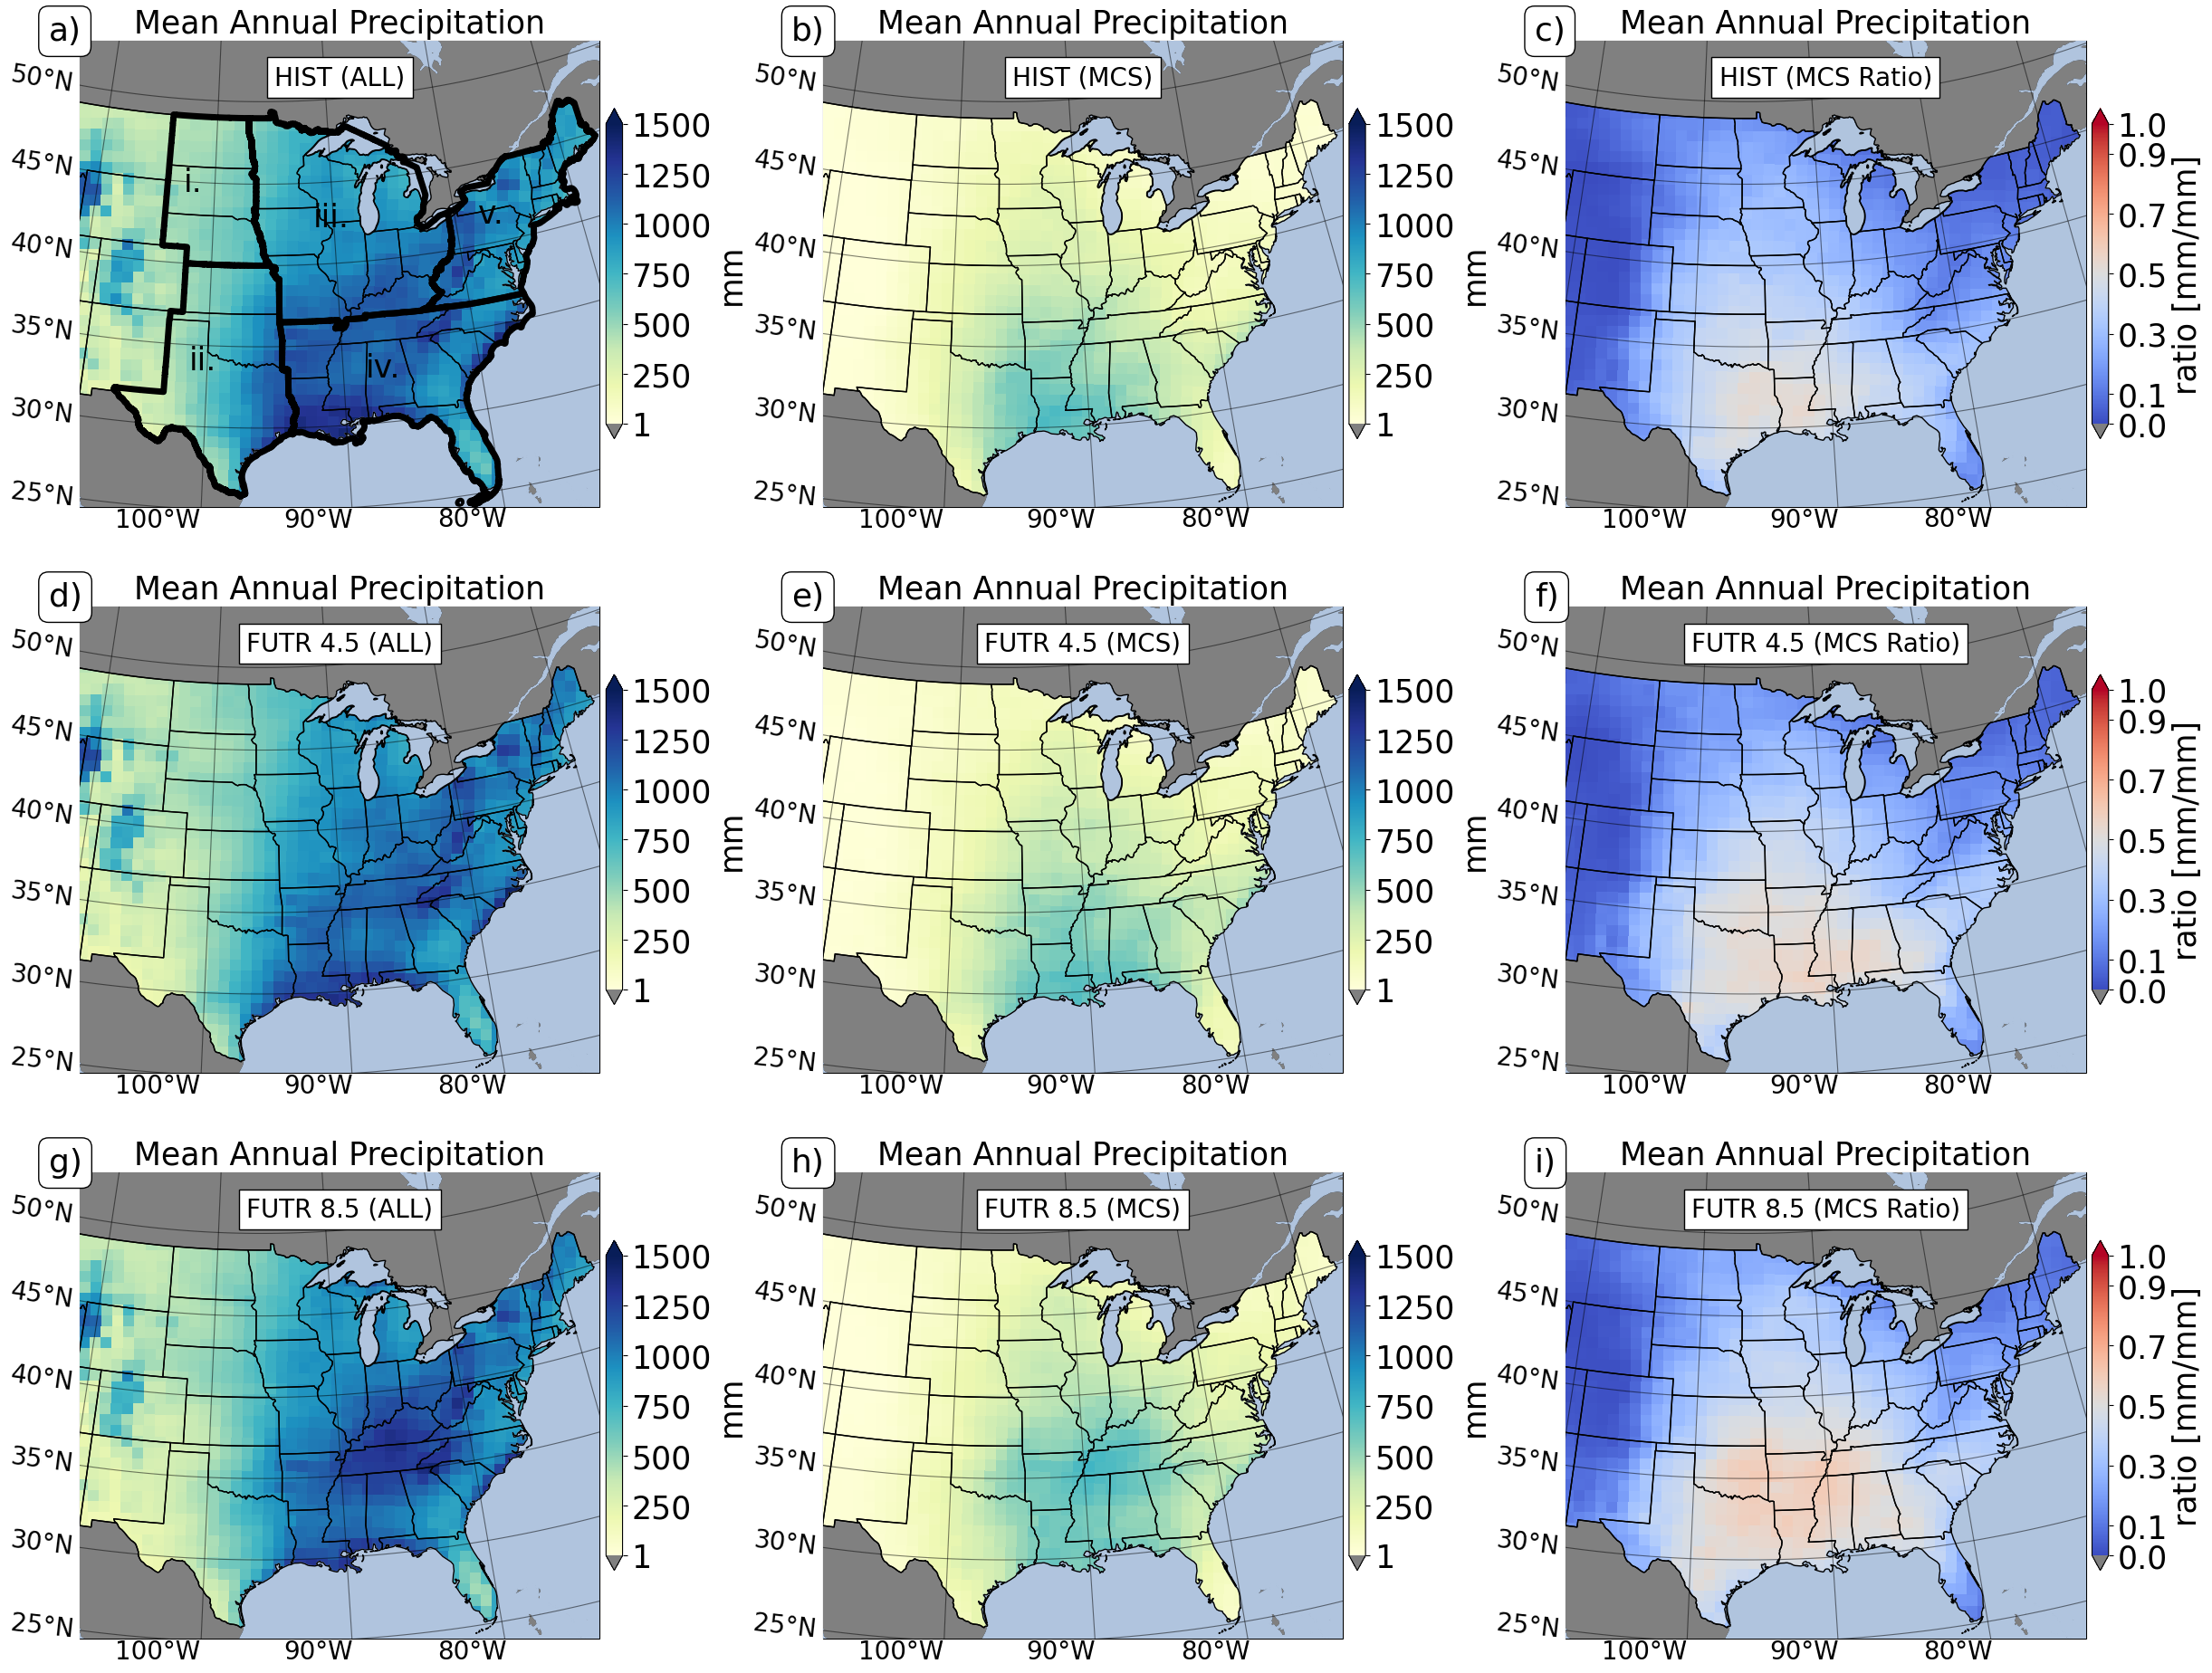

In [6]:
simulation_names = {'historical': 'HIST', 'future_4p5': 'FUTR 4.5', 'future_8p5': 'FUTR 8.5'}
event_types = {'all_rain': {'abbr': 'ALL', 'cmap': 'YlGnBu', 
                            'vmin': 1, 'vmax': 1500, 'ticks': [1, 250, 500, 750, 1000, 1250, 1500],
                            'units': 'mm'},
               'mcs_rain': {'abbr': 'MCS', 'cmap': 'YlGnBu', 
                            'vmin': 1, 'vmax': 1500, 'ticks': [1, 250, 500, 750, 1000, 1250, 1500],
                            'units': 'mm'}, 
               'mcs_ratio': {'abbr': 'MCS Ratio', 'cmap': 'coolwarm', 
                             'vmin': 0, 'vmax': 1, 'ticks': [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                             'units': 'ratio [mm/mm]'}}

for row, (sim_name, sim_abbr) in enumerate(simulation_names.items()):
    
    for col, (event_name, event_info) in enumerate(event_types.items()):
        
        ax_pos = 1 + ((row * 3) + col)

        simulation_means = data[event_name][sim_name]['annual_mean']
        
        ax = setup_map(ax_pos, 3, 3, ax_pos)
        
        ax.set_title(f"Mean Annual Precipitation")
        
        ax.annotate(f"{sim_abbr} ({event_info['abbr']})", (0.5,0.92), 
                    xycoords='axes fraction', ha='center', va='center',
                    fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                    color='k', zorder=15)
        
        if ax_pos == 1:
            
            draw_outlines(ax)
            
        cmap = plt.cm.get_cmap(event_info['cmap']).copy()
        cmap.set_under('grey')
        
        mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                            simulation_means['mcs_mask'], 
                            vmin=event_info['vmin'], vmax=event_info['vmax'],
                            transform=cartopy.crs.PlateCarree(), 
                            cmap=cmap, zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', 
                            ticks=event_info['ticks'], pad=0.01)
        
        cbar.set_label(label=event_info['units'])
        
plt.savefig(f"ratio_annual_052323.png", dpi=200, bbox_inches='tight')

### Plot precipitation differences

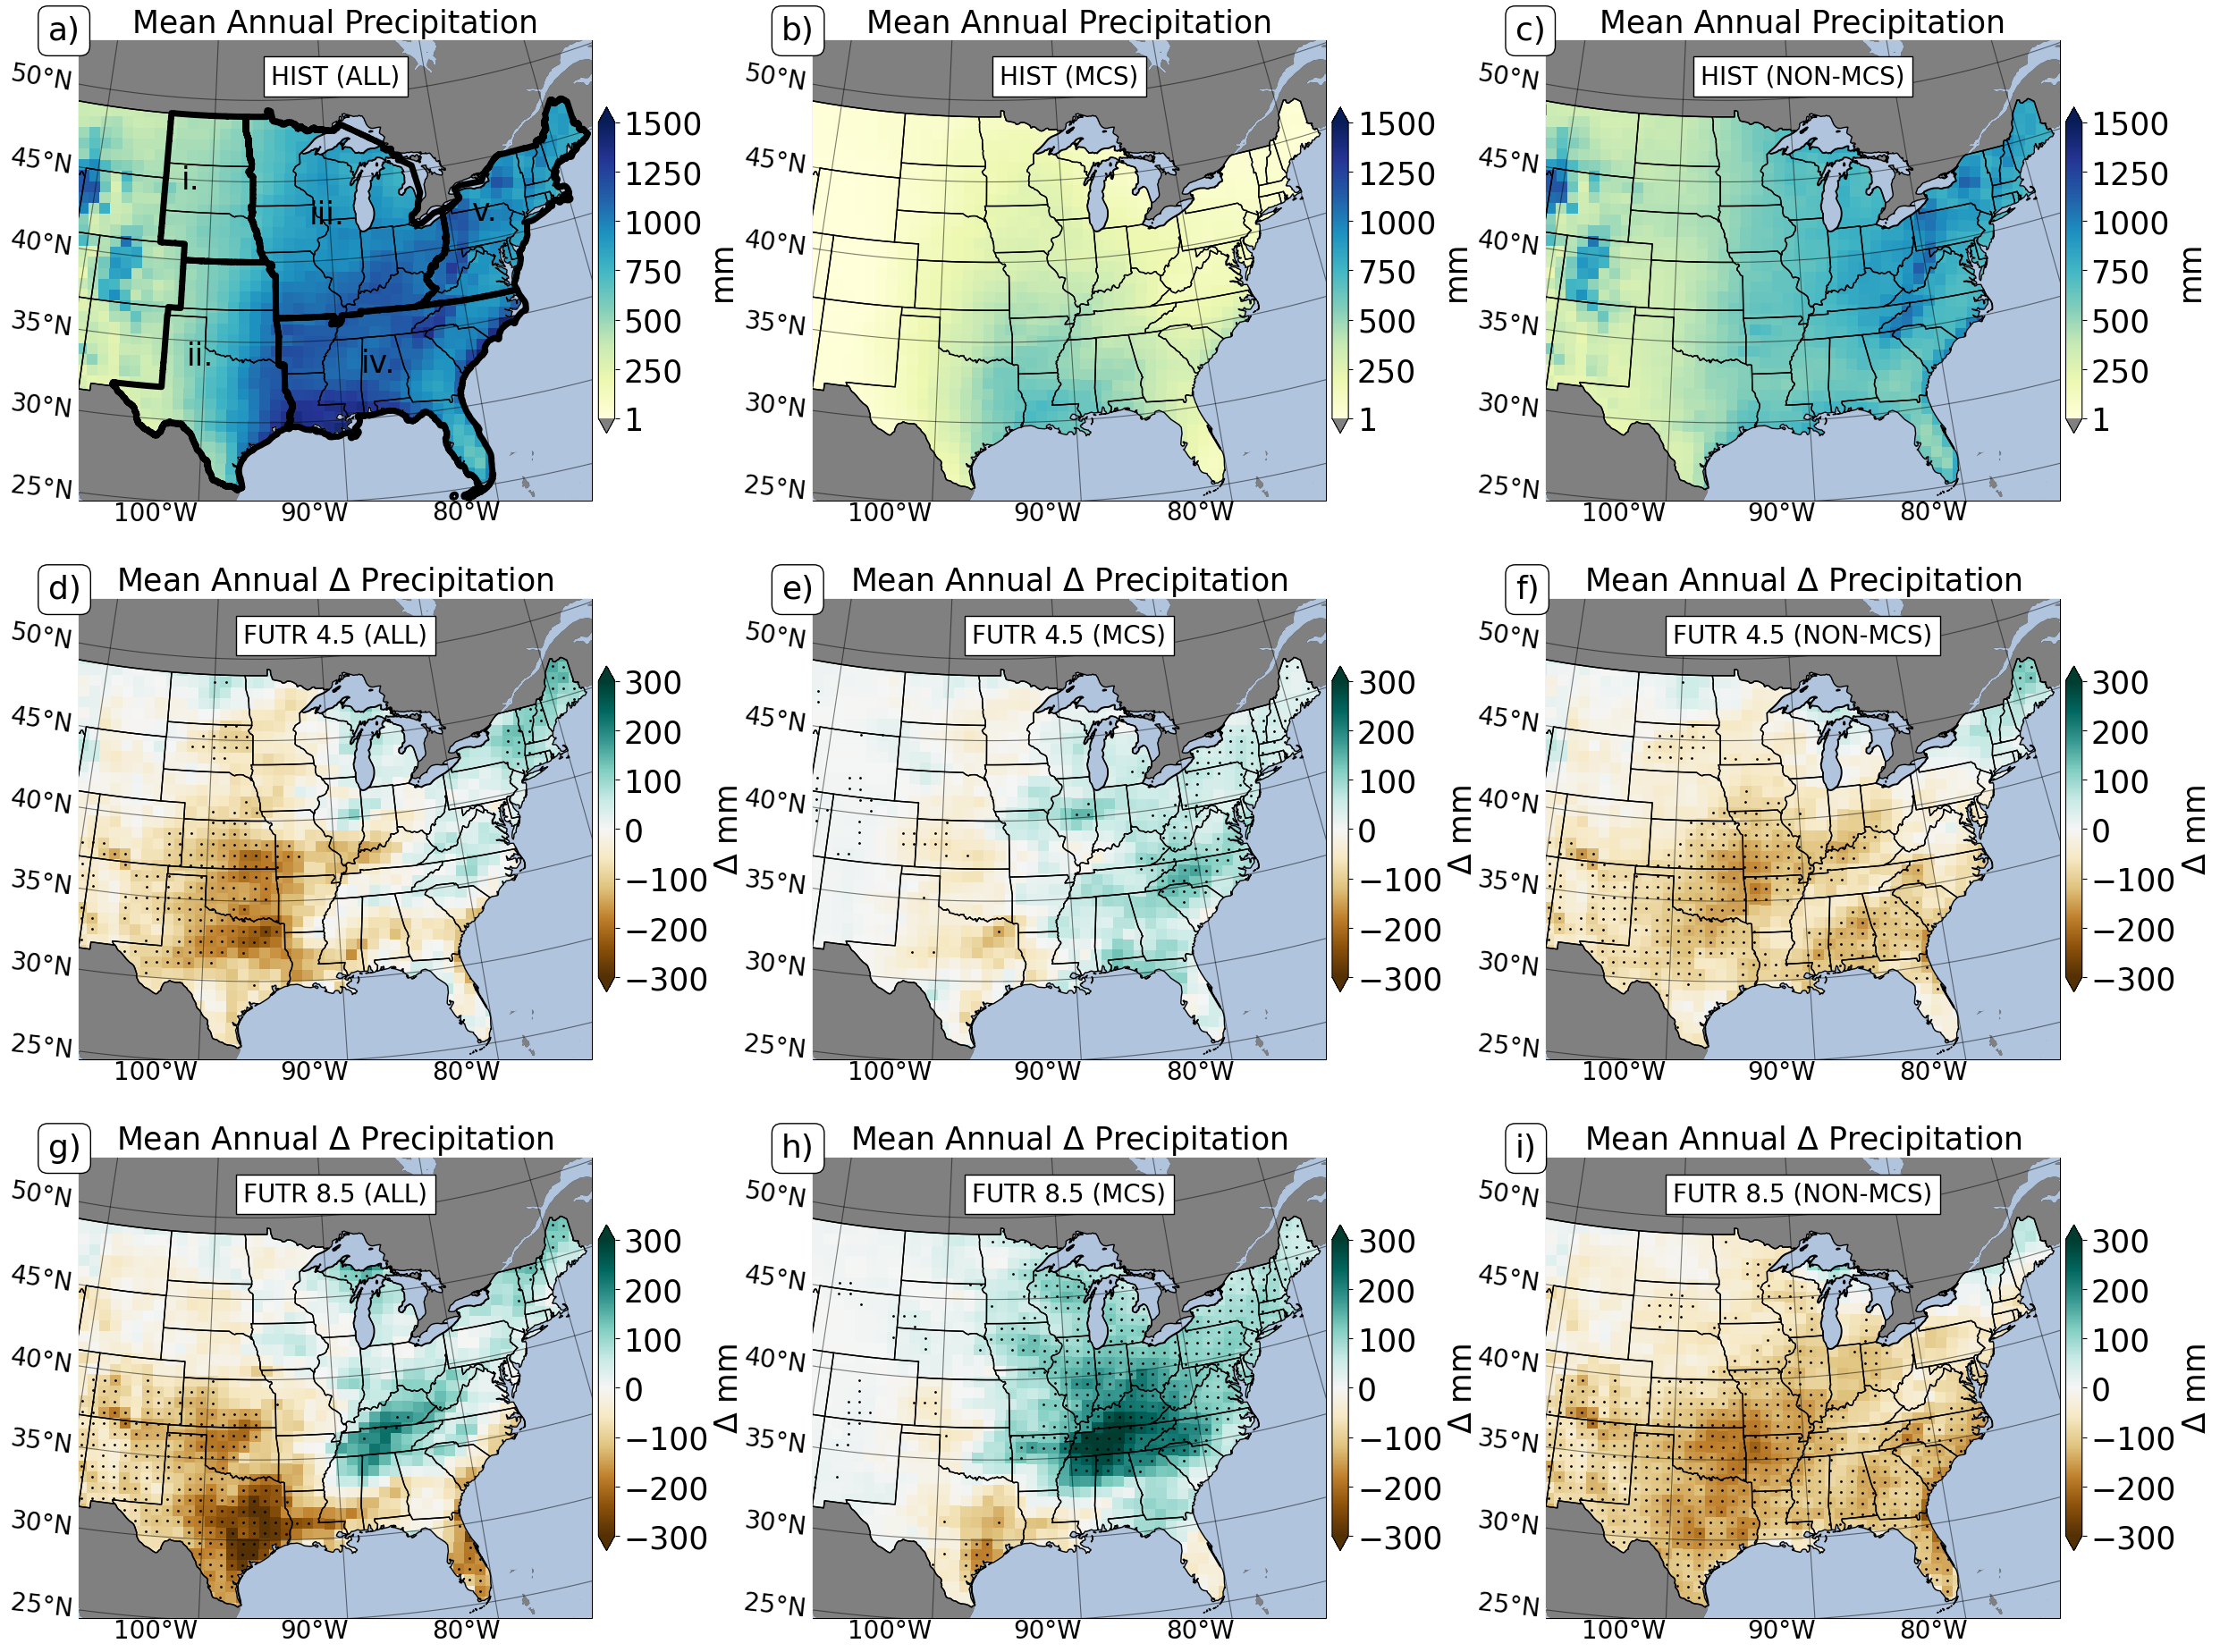

In [7]:
simulation_names = {'historical': {'abbr': 'HIST', 'cmap': 'YlGnBu', 
                                   'vmin': 1, 'vmax': 1500, 
                                   'ticks': [1, 250, 500, 750, 1000, 1250, 1500], 'units': 'mm'},
                    'future_4p5': {'abbr': 'FUTR 4.5', 'cmap': 'BrBG', 
                                   'vmin': -300, 'vmax': 300, 
                                   'ticks': [-300, -200, -100, 0, 100, 200, 300], 'units': '$\Delta$ mm'},
                    'future_8p5': {'abbr': 'FUTR 8.5', 'cmap': 'BrBG', 
                                   'vmin': -300, 'vmax': 300, 
                                   'ticks': [-300, -200, -100, 0, 100, 200, 300], 'units': '$\Delta$ mm'}}

event_types = {'all_rain': {'abbr': 'ALL'}, 'mcs_rain': {'abbr': 'MCS'}, 'non_mcs_rain': {'abbr': 'NON-MCS'}}


for row, (sim_name, sim_info) in enumerate(simulation_names.items()):
    for col, (event_name, event_info) in enumerate(event_types.items()):

        ax_pos = 1 + ((row * 3) + col)

        ax = setup_map(ax_pos, 3, 3, ax_pos)

        ax.annotate(f"{sim_info['abbr']} ({event_info['abbr']})", (0.5,0.92), 
                    xycoords='axes fraction', ha='center', va='center',
                    fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                    color='k', zorder=15)

        cmap = plt.cm.get_cmap(sim_info['cmap']).copy()
        
        simulation_means = data[event_name][sim_name]['annual_mean'] 
            
        ax.set_title(f"Mean Annual Precipitation")
                    
        if sim_name != 'historical':
            
            ax.set_title(f"Mean Annual $\Delta$ Precipitation")
            
            sim_means = data[event_name][sim_name]['annual_mean'] 
            hist_means = data[event_name]['historical']['annual_mean']
            
            simulation_means = sim_means - hist_means

        else:

            cmap.set_under('grey')
            
        if ax_pos == 1:

            draw_outlines(ax)

        mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                            simulation_means['mcs_mask'], 
                            vmin=sim_info['vmin'], vmax=sim_info['vmax'],
                            transform=cartopy.crs.PlateCarree(), 
                            cmap=cmap, zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', 
                            ticks=sim_info['ticks'], pad=0.01)

        cbar.set_label(label=sim_info['units'])
        
        sim_years = data[event_name][sim_name]['years_sums']
        hist_years = data[event_name]['historical']['years_sums']
        
        sig = grid_significance(hist_years['mcs_mask'].values, sim_years['mcs_mask'].values)

        pts_sig = np.where(sig < 0.05)

        ax.plot(simulation_means.lon.values[pts_sig],
                simulation_means.lat.values[pts_sig],
                'k.', ms=2, transform=cartopy.crs.PlateCarree(), zorder=5)
        
        
plt.savefig(f"Figure1_052323.png", dpi=200, bbox_inches='tight')

### Plot ratio changes

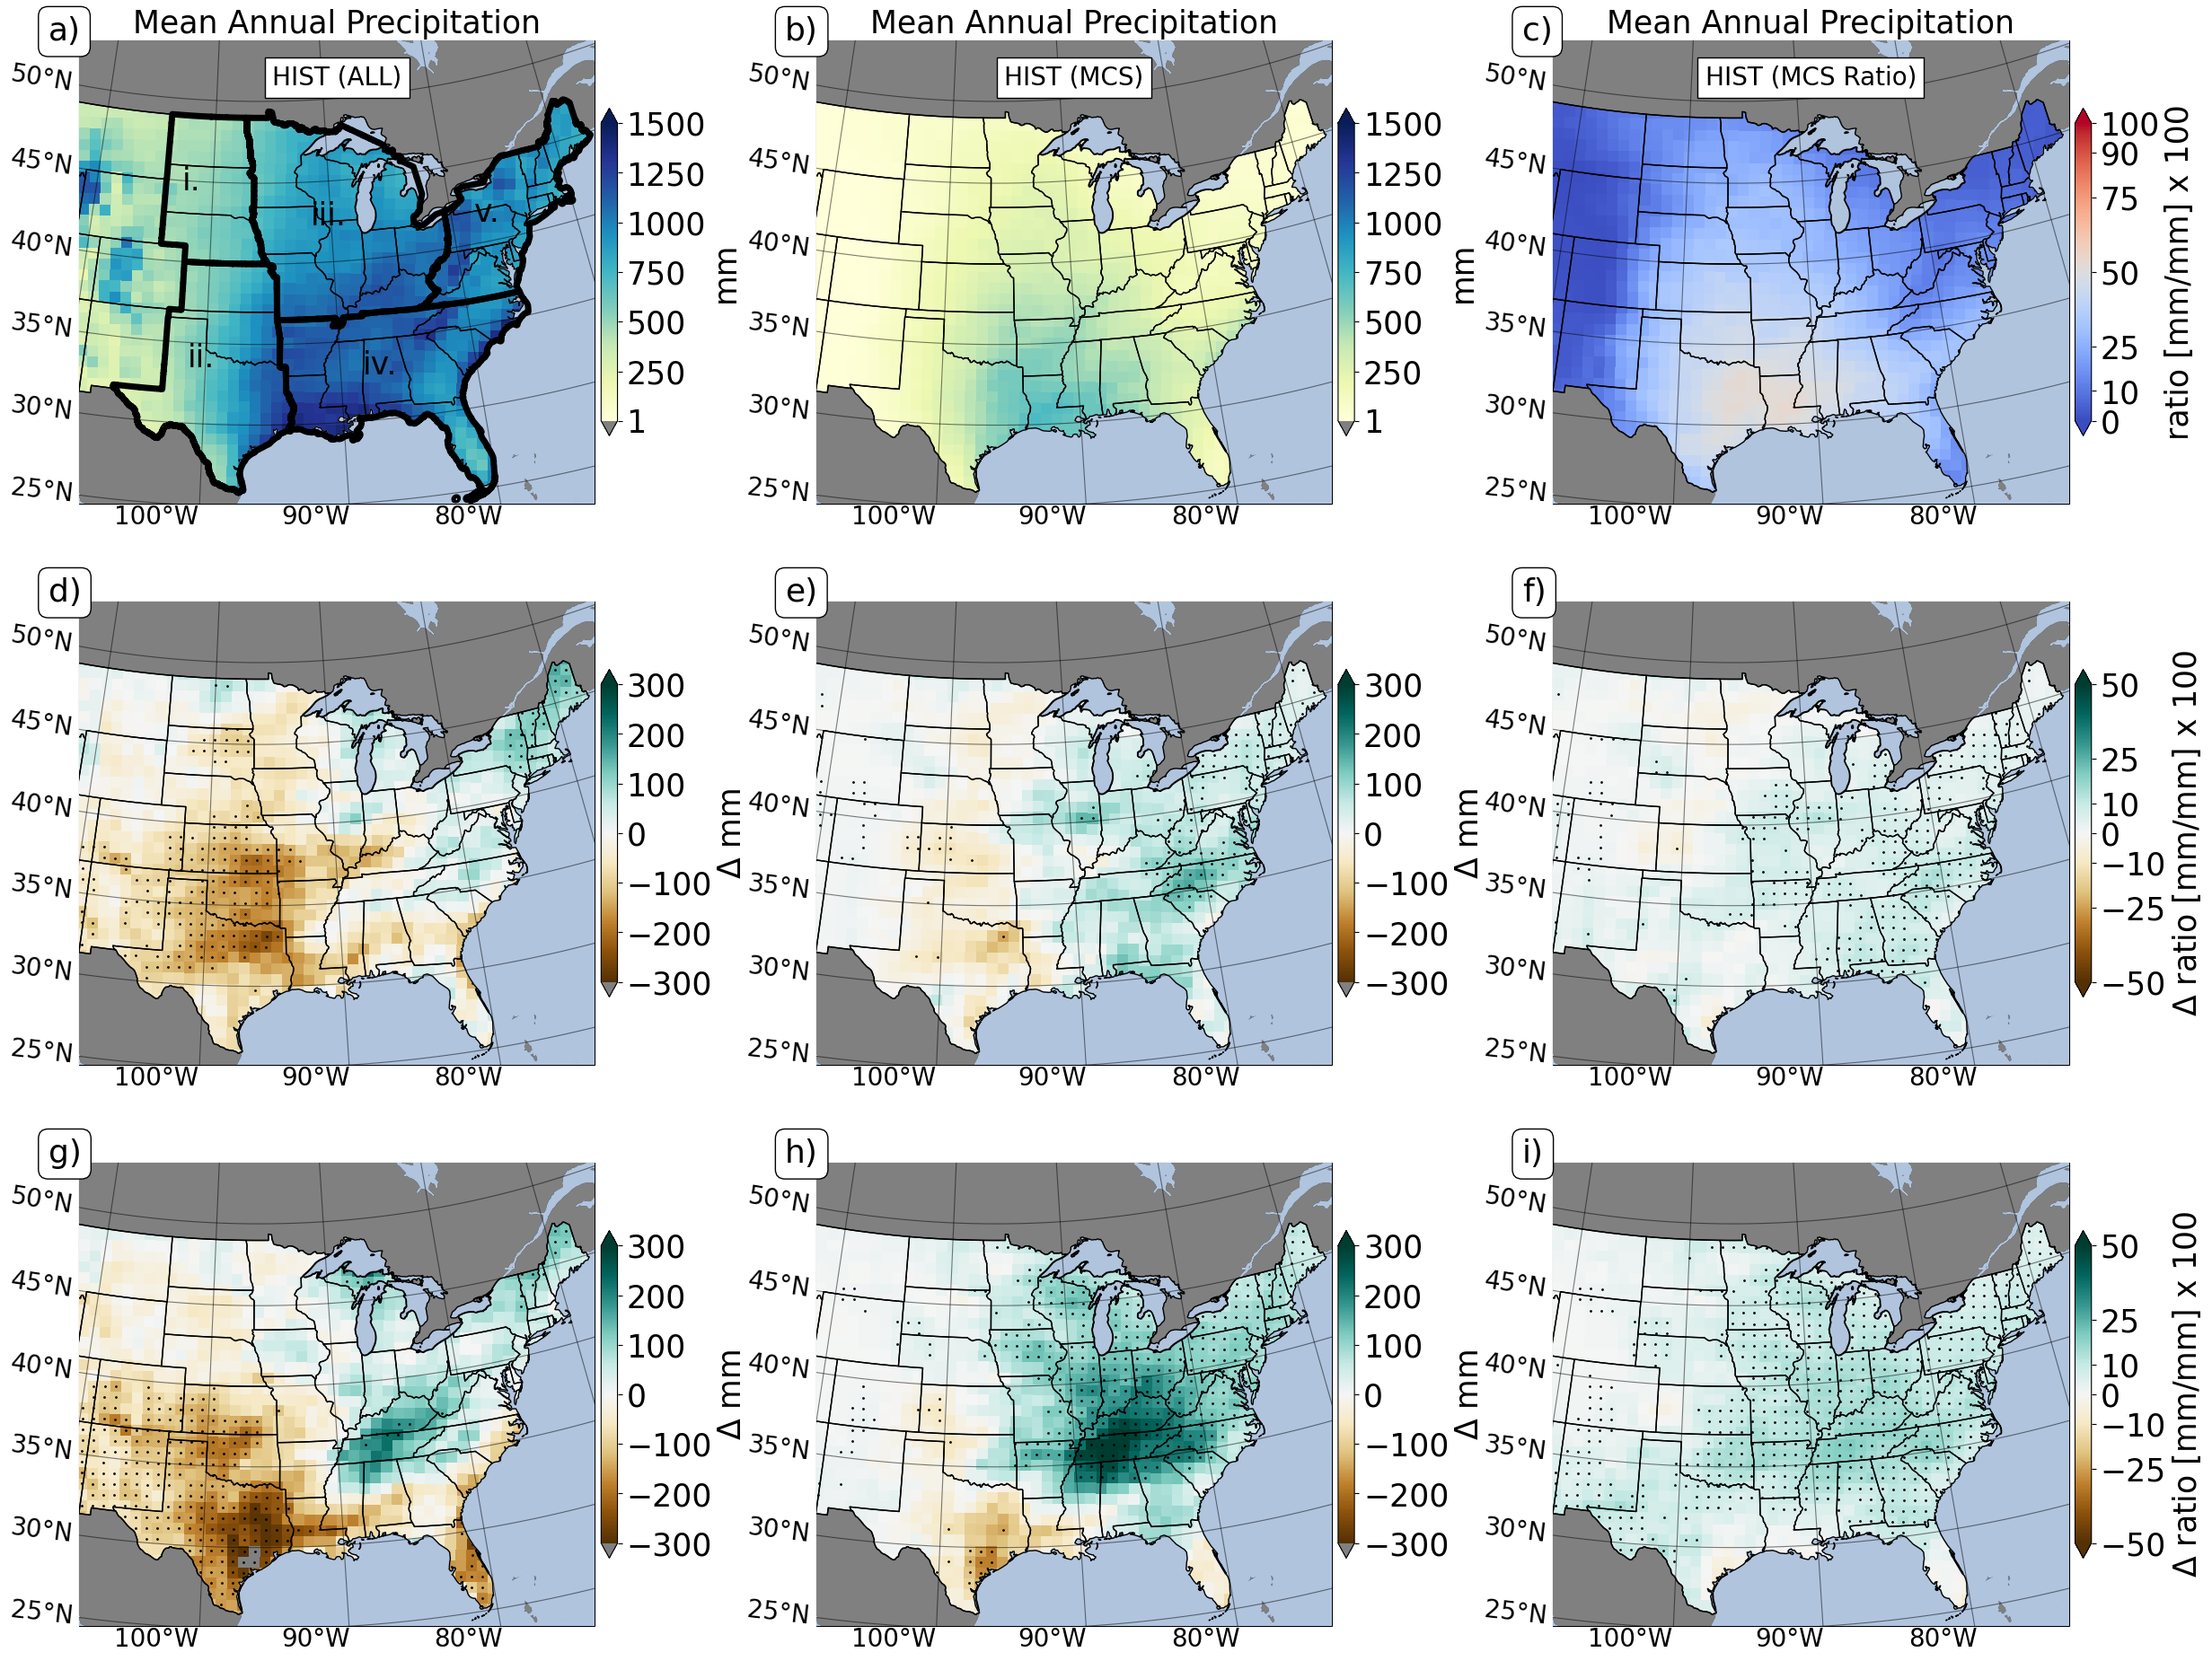

In [8]:
simulation_names = {'historical': {'all_rain': {'abbr': 'HIST', 'cmap': 'YlGnBu', 'vmin': 1, 'vmax': 1500, 'mult': 1, 
                                                'ticks': [1, 250, 500, 750, 1000, 1250, 1500], 'units': 'mm'},
                                   'mcs_rain': {'abbr': 'HIST', 'cmap': 'YlGnBu', 'vmin': 1, 'vmax': 1500, 'mult': 1,
                                                'ticks': [1, 250, 500, 750, 1000, 1250, 1500], 'units': 'mm'},
                                   'mcs_ratio': {'abbr': 'HIST', 'cmap': 'coolwarm', 'vmin': 0, 'vmax': 100, 'mult': 100,
                                                 'ticks': [0, 10, 25, 50, 75, 90, 100], 'units': 'ratio [mm/mm] x 100'}}}

event_types = {'all_rain': {'abbr': 'ALL'}, 'mcs_rain': {'abbr': 'MCS'}, 'mcs_ratio': {'abbr': 'MCS Ratio'}}


for row, (sim_name, sim_info) in enumerate(simulation_names.items()):
    for col, (event_name, event_info) in enumerate(event_types.items()):

        cmap = plt.cm.get_cmap(sim_info[event_name]['cmap']).copy()
        
        if event_name != 'mcs_ratio':
            cmap.set_under('grey')
                       
        ax_pos = 1 + ((row * 3) + col)

        ax = setup_map(ax_pos, 3, 3, ax_pos)

        ax.annotate(f"{sim_info[event_name]['abbr']} ({event_info['abbr']})", (0.5,0.92), 
                    xycoords='axes fraction', ha='center', va='center',
                    fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                    color='k', zorder=15)


        simulation_means = data[event_name][sim_name]['annual_mean'] 
            
        ax.set_title(f"Mean Annual Precipitation")
            
        if ax_pos == 1:

            draw_outlines(ax)

        mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                            simulation_means['mcs_mask'] * sim_info[event_name]['mult'], 
                            vmin=sim_info[event_name]['vmin'], vmax=sim_info[event_name]['vmax'],
                            transform=cartopy.crs.PlateCarree(), 
                            cmap=cmap, zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', 
                            ticks=sim_info[event_name]['ticks'], pad=0.01)

        cbar.set_label(label=sim_info[event_name]['units'])
        
simulation_names = {'future_4p5': {'all_rain': {'abbr': 'FUTR 4.5', 'cmap': 'BrBG', 
                                                'vmin': -300, 'vmax': 300, 'mult': 1,
                                                'ticks': [-300, -200, -100, 0, 100, 200, 300], 'units': '$\Delta$ mm'},
                                   'mcs_rain': {'abbr': 'FUTR 4.5', 'cmap': 'BrBG', 
                                                'vmin': -300, 'vmax': 300, 'mult': 1,
                                                'ticks': [-300, -200, -100, 0, 100, 200, 300], 'units': '$\Delta$ mm'},
                                   'mcs_ratio': {'abbr': 'HIST', 'cmap': 'BrBG', 'vmin': -50, 'vmax': 50, 'mult': 100,
                                                 'ticks': [-50, -25, -10, 0, 10, 25, 50], 'units': '$\Delta$ ratio [mm/mm] x 100'}},
                   'future_8p5': {'all_rain': {'abbr': 'FUTR 4.5', 'cmap': 'BrBG', 
                                               'vmin': -300, 'vmax': 300, 'mult': 1,
                                               'ticks': [-300, -200, -100, 0, 100, 200, 300], 'units': '$\Delta$ mm'},
                                   'mcs_rain': {'abbr': 'FUTR 4.5', 'cmap': 'BrBG', 
                                                'vmin': -300, 'vmax': 300, 'mult': 1,
                                                'ticks': [-300, -200, -100, 0, 100, 200, 300], 'units': '$\Delta$ mm'},
                                   'mcs_ratio': {'abbr': 'HIST', 'cmap': 'BrBG', 'vmin': -50, 'vmax': 50, 'mult': 100,
                                                 'ticks': [-50, -25, -10, 0, 10, 25, 50], 'units': '$\Delta$ ratio [mm/mm] x 100'}}}

for row, (sim_name, sim_info) in enumerate(simulation_names.items()):
    for col, (event_name, event_info) in enumerate(event_types.items()):

        cmap = plt.cm.get_cmap(sim_info[event_name]['cmap']).copy()
        
        if event_name != 'mcs_ratio':
            cmap.set_under('grey')
                       
        ax_pos = 1 + (((row+1) * 3) + col)

        ax = setup_map(ax_pos, 3, 3, ax_pos)
        
        simulation_means = data[event_name][sim_name]['annual_mean']
        historical_means = data[event_name]['historical']['annual_mean']
        
        mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                    sim_info[event_name]['mult'] * (simulation_means['mcs_mask'].values - historical_means['mcs_mask'].values), 
                    vmin=sim_info[event_name]['vmin'], vmax=sim_info[event_name]['vmax'],
                            transform=cartopy.crs.PlateCarree(), 
                            cmap=cmap, zorder=5)

        cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', 
                            ticks=sim_info[event_name]['ticks'], pad=0.01)

        cbar.set_label(label=sim_info[event_name]['units'])
        
        sim_years = data[event_name][sim_name]['years_sums']
        hist_years = data[event_name]['historical']['years_sums']
        
        sig = grid_significance(hist_years['mcs_mask'].values, sim_years['mcs_mask'].values)

        pts_sig = np.where(sig < 0.05)

        ax.plot(simulation_means.lon.values[pts_sig],
                simulation_means.lat.values[pts_sig],
                'k.', ms=2, transform=cartopy.crs.PlateCarree(), zorder=5)